<a href="https://colab.research.google.com/github/destaerc/Yverdon_les_tropiques/blob/main/Import_donn%C3%A9es_stations_decentlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt


# Répertoire de travail
# Mettre à jour d'après le dossier contenant les données !

dossier_donnees = r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Decentlab"

os.chdir(dossier_donnees)
print("Nouveau répertoire courant :", os.getcwd())

Nouveau répertoire courant : C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Decentlab


In [2]:
# Chargement des fichiers CSV avec ajout de la colonne 'station'
def charger_donnees_csv(liste_chemins_dossiers):
    li = []
    for chemin_dossier in liste_chemins_dossiers:
        all_files = glob.glob(os.path.join(chemin_dossier, "*.csv"))
        if not all_files:
            print(f"No CSV files found in {chemin_dossier}. Skipping this directory.")
            continue # Skip to the next directory if no files are found

        for filename in all_files:
            # Extraire le nom de la station à partir du nom de fichier
            station_name = os.path.basename(filename).split("__")[0].replace("timeseries_table_", "").replace("_", " ").strip()
            df = pd.read_csv(filename, index_col=None, header=0, sep=';')
            df['station'] = station_name
            li.append(df)

    if not li:
        print("No data loaded from any directory.")
        return pd.DataFrame() # Return an empty DataFrame if no files are found in any directory

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

# Charger les données
# Provide a list of directories to the function
dossiers_donnees_list = [
    r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Decentlab\6_mai_8_aout_2025",
    r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Fichiers Decentlab\8_aout_2025"
]
df = charger_donnees_csv(dossiers_donnees_list)

# Renommer les colonnes pour cohérence
# Check if the DataFrame is not empty before renaming columns
if not df.empty:
    df = df.rename(columns={
        'Timestamp': 'timestamp',
        'Temperature': 'temperature',
        'Humidity': 'humidity',
        'humidity': 'humidity'  # au cas où certaines colonnes sont déjà en minuscules
    })


In [3]:
# Calcul des moyennes horaires
def calculer_moyenne_horaire(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['heure'] = df['timestamp'].dt.floor('h')
    moyennes = df.groupby(['station', 'heure'])[['temperature', 'humidity']].mean().reset_index()
    return moyennes

# Calculate the hourly averages using the combined data
moyennes = calculer_moyenne_horaire(df)

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['heure'] = df['timestamp'].dt.floor('h')
moyennes = df.groupby(['station', 'heure'])[['temperature', 'humidity']].mean().reset_index()

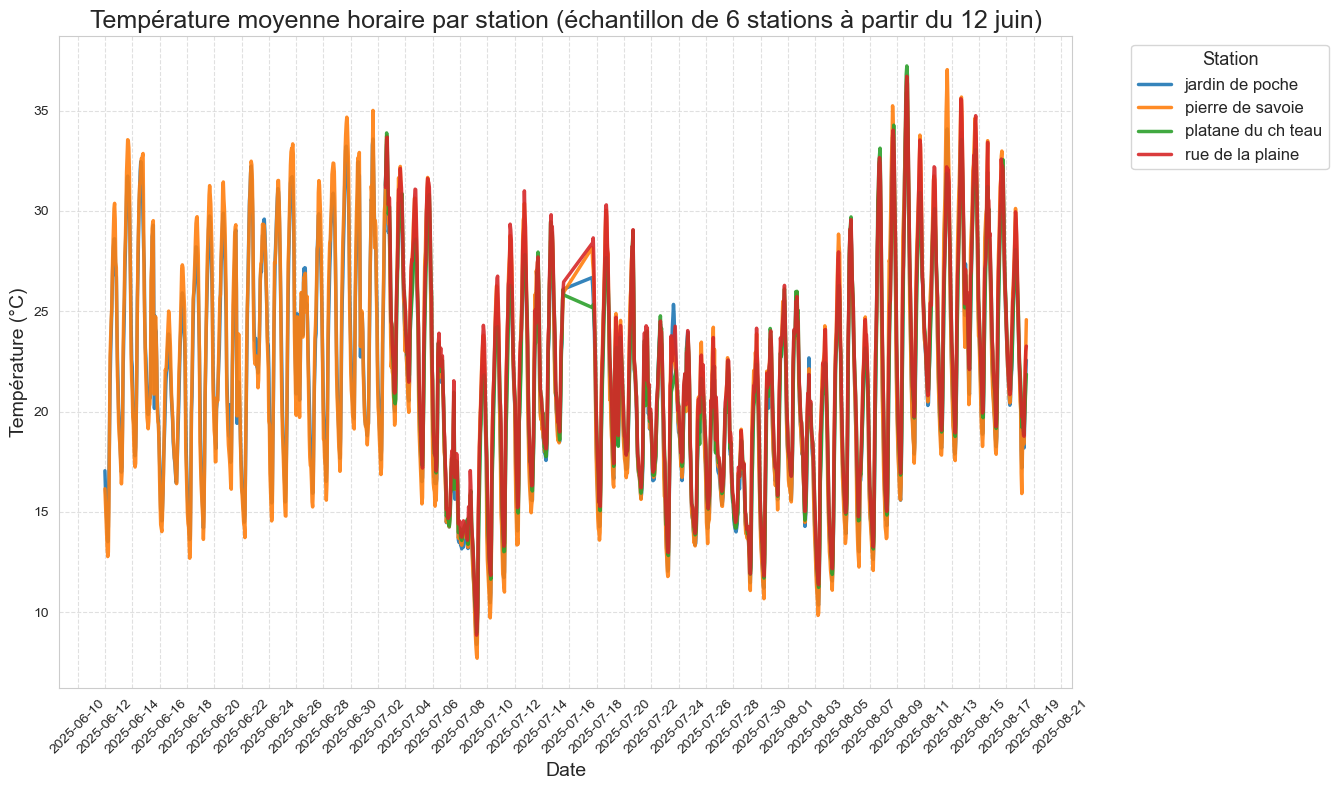

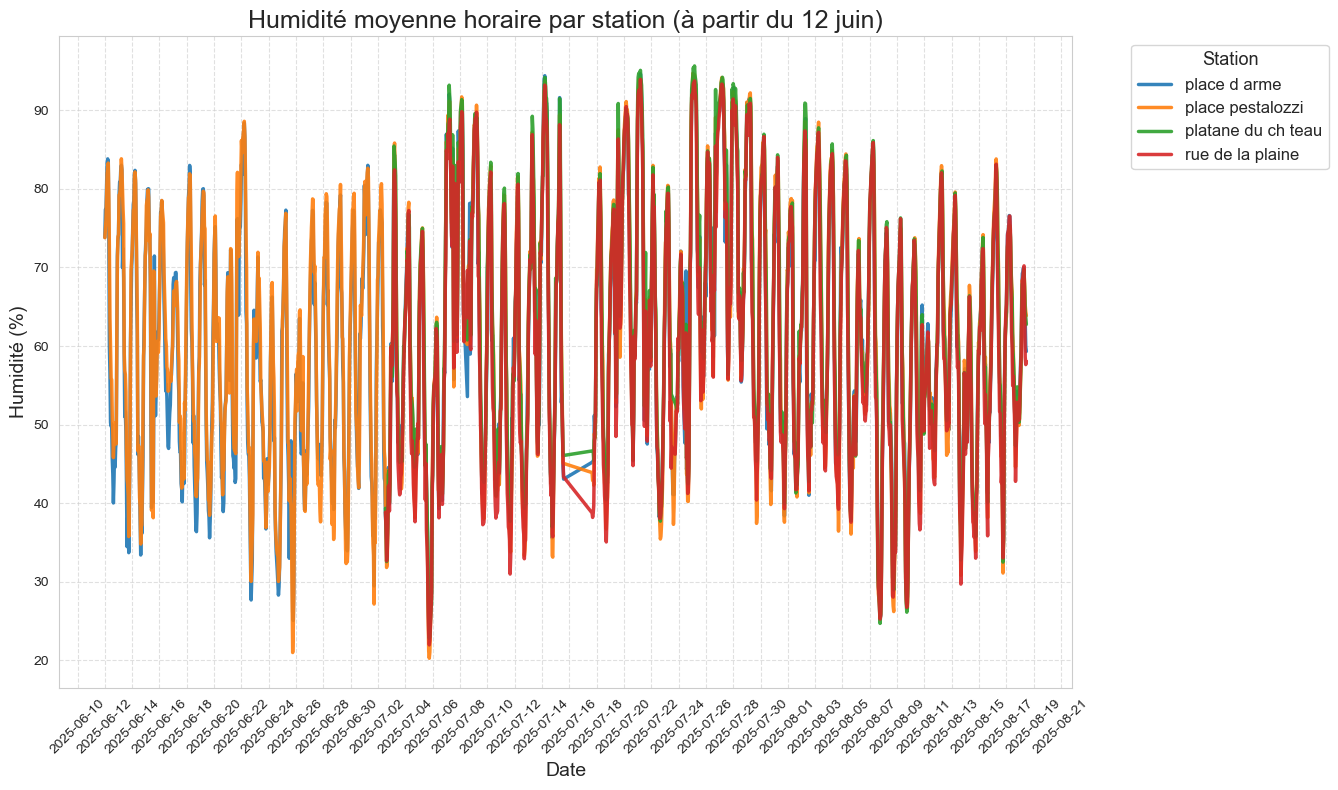

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

start_date = '2025-06-12'
filtered_moyennes_viz = moyennes[moyennes['heure'] >= start_date].copy()

def plot_time_series(data, y_var, y_label, title, sample_stations=None, figsize=(16, 8)):
    """
    Trace une série temporelle pour une variable donnée,
    avec option de prendre un échantillon aléatoire de stations.

    Args:
        data: DataFrame avec colonnes 'heure', y_var, 'station'
        y_var: nom de la colonne à tracer (ex: 'temperature')
        y_label: label pour l'axe y
        title: titre du graphique
        sample_stations: int ou None, nombre de stations à échantillonner (None = toutes)
        figsize: taille de la figure (tuple)
    """
    # Échantillonnage des stations si demandé
    if sample_stations is not None:
        stations_unique = data['station'].unique()
        if sample_stations < len(stations_unique):
            sampled = np.random.choice(stations_unique, size=sample_stations, replace=False)
            data = data[data['station'].isin(sampled)]

    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    palette = sns.color_palette("tab10", n_colors=data['station'].nunique())

    ax = sns.lineplot(
        data=data,
        x='heure',
        y=y_var,
        hue='station',
        linewidth=2.5,
        alpha=0.9,
        palette=palette
    )
    ax.set_title(title, fontsize=18)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=13)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Exemple d’appel pour un échantillon de 6 stations (température)
plot_time_series(
    filtered_moyennes_viz,
    y_var='temperature',
    y_label='Température (°C)',
    title="Température moyenne horaire par station (échantillon de 6 stations à partir du 12 juin)",
    sample_stations=4
)

# Tracer toutes les stations pour l'humidité (attention si beaucoup de stations)
plot_time_series(
    filtered_moyennes_viz,
    y_var='humidity',
    y_label='Humidité (%)',
    title="Humidité moyenne horaire par station (à partir du 12 juin)",
    sample_stations=4  # Toutes les stations
)


In [6]:
output_dir = r"C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "decentlab_moyennes_horaires.csv")
moyennes.to_csv(output_path, index=False, sep=";")
print(f"✅ Fichier '{output_path}' exporté avec succès.")

✅ Fichier 'C:\Users\vincent.destaerc\Documents\GitHub\Yverdon_les_tropiques\Export csv\decentlab_moyennes_horaires.csv' exporté avec succès.
